#  StarGAN Tutorial (Basic) - Make Fake Images

**For beginners who are unfamiliar with Python code**, I solved the pytorch official code with Jupyter Notebook.

Through this kernel, I will implement StarGAN model from scratch with PyTorch and test them with Kaggle data. 

Then.. let's get started!

---

# StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation
[--> paper](https://openaccess.thecvf.com/content_cvpr_2018/papers/Choi_StarGAN_Unified_Generative_CVPR_2018_paper.pdf)

![paper](https://openaccess.thecvf.com/content_cvpr_2018/papers/Choi_StarGAN_Unified_Generative_CVPR_2018_paper.pdf)

## Main Reference
1. [PyTorch-GAN | Github/eriklindernoren | Collection of PyTorch implementations of GAN](https://github.com/sw-song/PyTorch-GAN)
2. [stargan | Github/yunjey | Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation](https://github.com/yunjey/stargan)

## Index
```
Step 1. Import Libraries
Step 2. Initial Setting
Step 3. Define Generator
Step 4. Define Discriminator
Step 5. Define Loss function and Initialize Loss weights
Step 6. Initialize Generator and Discriminator
Step 7. GPU Setting
Step 8. Weight Setting
Step 9. Configure Optimizers
Step 10. Define CelebADataset Class for handling labeled dataset
Step 11. Set transforms and Configure Dataloader for training
Step 12. Set transforms and Configure Dataloader for testing
Step 13. Define Gradient Penalty Function
Step 14. Define function to get sample images with input label list
Step 15. Training
```
---

If it's your first time gan, it's good to see [🌈GAN Basic Tutorial : Generate MNIST Image](https://www.kaggle.com/songseungwon/gan-basic-tutorial-generate-mnist-image). This kernel requires an understanding of the basic gan model.

And you need to understand `CycleGAN` Architecture. See also [🌈CycleGAN Tutorial : Monet-to-Photo⛵️](https://www.kaggle.com/songseungwon/cyclegan-tutorial-monet-to-photo)If you are unfamiliar with `CycleGAN`

### Step 1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import itertools
import glob
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd

import torch.nn as nn
import torch.nn.functional as F
import torch

## Step 2. Initial Setting

In [ ]:
# ---------
# training
# ---------
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training (suggested default : 200)
batch_size = 16 # size of the batches. suggested.
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 4 # epoch fom which to start lr decay (suggested default : 100)

# ---------
# image data
# ---------
root = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
img_height = 128 # size of image height
img_width = 128 # size of image width
channels = 3 # number of image channels

# ---------
# modeling
# ---------
residual_blocks = 6 # number of residual blocks in generator
n_critic = 5 # number of training iterations for WGAN discriminator
selected_attrs = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'] # selected attributes for the CelebA dataset

In [ ]:
# number of cpu (in kaggle server - Accelerator : GPU)
!cat /proc/cpuinfo | grep processor

In [ ]:
n_cpu = 2 # number of cpu threads to use during batch generation

In [ ]:
c_dim = len(selected_attrs) # number of input-attributes
c_dim

In [ ]:
img_shape = (channels, img_height, img_width) # set image shape for pytorch
img_shape

In [ ]:
cuda = torch.cuda.is_available()
cuda

### Step 3. Define Generator

![image](https://miro.medium.com/max/1494/1*KzE7AMq8xbq6vOe1teaDDg.png)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        conv_block = [
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True)
        ]
        
        self.conv_block = nn.Sequential(*conv_block) # list-unpacking
    
    def forward(self, x):
        return x + self.conv_block(x)

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, img_shape=(3,128,128), res_blocks=9, c_dim=5):
        super(GeneratorResNet, self).__init__()
        channels, img_size, _ = img_shape
        
        # Initial convolution block
        model = [
            nn.Conv2d(channels+c_dim, 64, 7, stride=1, padding=3, bias=False), # in_channels = channels+c_dim (domain added in channel)
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        curr_dim = 64
        for _ in range(2):
            model += [
                nn.Conv2d(curr_dim, curr_dim*2, 4, stride=2, padding=1, bias=False), 
                nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True)
            ]
            curr_dim *= 2 # 64->128
        
        # Residual blocks
        for _ in range(res_blocks): # 9-loop
            model += [ResidualBlock(curr_dim)] # 128->128
        
        # Upsampling
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(curr_dim, curr_dim//2, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim = curr_dim//2 # 128->64
            
        # Output layer
        model += [
            nn.Conv2d(curr_dim, channels, 7, stride=1, padding=3), # 64 -> 3 (return RGB Image)
            nn.Tanh() # -1 < tanh(x) < 1
        ]
        
        self.model = nn.Sequential(*model) # Unpack the list of layers 
    
    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x,c), 1) # get image(x) and domain(c) 
        return self.model(x)

> Read More
- [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [UnPooling / UpSampling / Deconvolution / Transposed convolution](https://www.programmersought.com/article/42421095350/)
- [Calculating the Output Size of Convolutions and Transpose Convolutions](http://makeyourownneuralnetwork.blogspot.com/2020/02/calculating-output-size-of-convolutions.html)
- Example | Upsampling - (stride = 2, padding = 1)
![image](https://1.bp.blogspot.com/-bVWdYb2CLX4/XkrI1i27G4I/AAAAAAAAArQ/mlykCrbvqQoCaXPK-Oh4tqGi04RpukqbACEwYBhgL/s640/appendix_C_eg_7.png)
- [torch.nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)
- Example | Tanh activate function
![image](https://pytorch.org/docs/stable/_images/Tanh.png)


### Step 4. Define Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_shape=(3,128,128), c_dim=5, n_strided=6):
        super(Discriminator, self).__init__()
        channels, img_size, _ = img_shape
        
        def discriminator_block(in_filters, out_filters):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1), 
                nn.LeakyReLU(0.01)
            ]
            return layers
        
        layers = discriminator_block(channels, 64)
        curr_dim = 64
        for _ in range(n_strided-1):
            layers.extend(discriminator_block(curr_dim, curr_dim*2))
            curr_dim *= 2
            
        self.model = nn.Sequential(*layers)
        
        # Output 1 : PatchGAN
        self.out1 = nn.Conv2d(curr_dim, 1, 3, padding=1, bias=False)
        # Output 2 : Class prediction
        kernel_size = img_size//(2**n_strided)
        self.out2 = nn.Conv2d(curr_dim, c_dim, kernel_size, bias=False)
        
    def forward(self, img):
        feature_repr = self.model(img)
        out_adv = self.out1(feature_repr) # real or fake
        out_cls = self.out2(feature_repr) # matching-domain
        return out_adv, out_cls.view(out_cls.size(0), -1)
        

### Step 5. Define Loss function and Initialize Loss weights

In [ ]:
# Loss function - Cycle loss
criterion_cycle = torch.nn.L1Loss()

In [ ]:
# Loss function - Domain-Class loss
def criterion_cls(logit, target):
    return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)

In [ ]:
# Loss weights (suggested default in paper)
lambda_cls = 1
lambda_rec = 10
lambda_gp = 10

### Step 6. Initialize Generator and Discriminator

In [ ]:
generator = GeneratorResNet(img_shape=img_shape, res_blocks=residual_blocks, c_dim=c_dim)
discriminator = Discriminator(img_shape=img_shape, c_dim=c_dim)

### Step 7. GPU Setting

In [ ]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_cycle.cuda()

### Step 8. Weight Setting

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution

In [ ]:
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal);

> Read More
- [CycleGAN Tutorial : Monet-to-Photo - Step 8. Weight Setting](https://www.kaggle.com/songseungwon/cyclegan-tutorial-monet-to-photo)

### Step 9. Configure Optimizers

In [ ]:
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(b1,b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=lr,
    betas=(b1,b2)
)

### Step 10. Define CelebADataset Class for handling labeled dataset

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train', attributes=None):
        self.transform = transforms.Compose(transforms_)
        
        self.selected_attrs = attributes
        self.files = sorted(glob.glob('%s/*.jpg' %root))
        if mode == 'train':
            self.files = self.files[:1000] # 1,000
        elif mode == 'test':
            self.files = self.files[1000:1200] # 200
        self.annotations = self.get_annotations()
        
    def get_annotations(self):
        """Extracts annotations for CelebA"""
        label_df = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')
        label_df = label_df[:12000]
        label_names = list(label_df.columns)[1:]
        annotations = {}
        for _, row in label_df.iterrows():
            filename = row.values[0]
            values = row[1:]
            labels = []
            for attr in selected_attrs: # selected_attr = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Young"]
                idx = label_names.index(attr) # get index of selected 'attr'
                labels.append(1 * (values[idx]==1))
            annotations[filename] = labels
        return annotations
    
    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]
        filename = filepath.split('/')[-1]
        img = self.transform(Image.open(filepath))
        label = self.annotations[filename]
        label = torch.FloatTensor(np.array(label))
        return img, label
    
    def __len__(self):
        return len(self.files)

> TEST CODE : read csv file (check labels)

In [ ]:
label_df = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')

In [ ]:
label_df.head()

In [ ]:
label_df = label_df[:12000]
label_df

In [ ]:
label_names = list(label_df.columns)[1:]
label_names

In [ ]:
print(*list(label_df.iloc[0]))

In [ ]:
label_df.iloc[0][0]

In [ ]:
print(*list(label_df.iloc[0][1:]))

In [ ]:
for _, row in label_df.iterrows():
    print('filename :\n\t',row.values[0])
    print('one-hot-label :\n\t',row.values[1:])
    break

In [ ]:
annotations = {}
for _, row in tqdm(label_df.iterrows(), total=len(label_df)):
    filename = row.values[0]
    values = row[1:]
    labels = []
    for attr in selected_attrs: # selected_attr = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Young"]
        idx = label_names.index(attr) # get index of selected 'attr'
        labels.append(1 * (values[idx]==1))
    annotations[filename] = labels

In [ ]:
for i in range(1,10):
    sample_filename = '00000{}.jpg'.format(i)
    print('filename: ',sample_filename)
    print('encoded-label:',annotations[sample_filename])

> TEST CODE : getitem

In [ ]:
sample_train_files = sorted(glob.glob('%s/*.jpg' %root))
sample_train_files = sample_train_files[:10000] # 10,000

In [ ]:
sample_index = 23
sample_train_file_path = sample_train_files[sample_index % len(sample_train_files)]
sample_train_file_path

In [ ]:
sample_filename = sample_train_file_path.split('/')[-1]
sample_filename

In [ ]:
sample_transforms = [
    transforms.Resize(int(1.12*img_height), Image.BICUBIC),
    transforms.ToTensor()
]
sample_transform = transforms.Compose(sample_transforms)
sample_img = sample_transform(Image.open(sample_train_file_path))
sample_img.shape

In [ ]:
plt.imshow(sample_img.permute(1,2,0))
plt.axis('off');

In [ ]:
sample_label = annotations[sample_filename]
sample_label

In [ ]:
torch.FloatTensor(np.array(sample_label))

### Step 11. Set transforms and Configure Dataloader for training

In [ ]:
# transforms
train_transforms = [
    transforms.Resize(int(1.12*img_height), Image.BICUBIC),
    transforms.RandomCrop(img_height),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]

In [ ]:
# dataloader
dataloader = DataLoader(
    CelebADataset(
        root, transforms_=train_transforms, mode='train', attributes=selected_attrs
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu
)

> TEST CODE : root

In [ ]:
len(glob.glob('%s/*.jpg'%root))

### Step 12. Set transforms and Configure Dataloader for testing

In [ ]:
# transforms
val_transforms = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]

In [ ]:
# dataloader
val_dataloader = DataLoader(
    CelebADataset(
        root, transforms_=val_transforms, mode='test', attributes=selected_attrs
    ),
    batch_size=10,
    shuffle=True,
    num_workers=1
)

### Step 13. Define Gradient Penalty Function

In [ ]:
# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0),1,1,1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha*real_samples + ((1-alpha)*fake_samples)).requires_grad_(True) # requires_grad inplace
    d_interpolates, _ = D(interpolates) # adv_info, cls_info = discriminator(interpolated image)
    fake = Tensor(np.ones(d_interpolates.shape))
    # Get gradient w.r.t interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0),-1)
    gradient_penalty = ((gradients.norm(2, dim=1)-1)**2).mean()
    return gradient_penalty

> TEST CODE : gradient penalty

In [ ]:
for i, (imgs, labels) in enumerate(dataloader):
    print(imgs.size())
    break

In [ ]:
temp_real_samples = torch.from_numpy(np.random.randn(16,3,128,128))
temp_fake_samples = torch.from_numpy(np.random.randn(16,3,128,128))
temp_real_samples = temp_real_samples.type(torch.FloatTensor).cuda()
temp_fake_samples = temp_fake_samples.type(torch.FloatTensor).cuda()
print(temp_real_samples.size(), temp_fake_samples.size())

In [ ]:
temp_alpha = torch.FloatTensor(np.random.random((temp_real_samples.size(0),1,1,1))).cuda()
temp_alpha.size()

In [ ]:
temp_interpolates = (temp_alpha*temp_real_samples + (1-temp_alpha)*temp_fake_samples).requires_grad_(True)
temp_interpolates.size()

In [ ]:
temp_d_interpolates, temp_cls = discriminator(temp_interpolates)
print(temp_d_interpolates.size()) # 16 batches and 1 output channel
print(temp_d_interpolates[0]) 
print(temp_cls.size()) # 16 batches and 5 domains
print(temp_cls) # predict `real or fake` probabilities of each domain

In [ ]:
temp_fake = Tensor(np.ones(temp_d_interpolates.shape))
temp_fake.size()

In [ ]:
temp_gradients = autograd.grad(
        outputs=temp_d_interpolates, # size : [16, 1, 2, 2]
        inputs=temp_interpolates, # size : [16, 3, 128, 128]
        grad_outputs=temp_fake, # size : [16, 1, 2, 2]
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
temp_gradients.size()

In [ ]:
temp_gradients = temp_gradients.view(temp_gradients.size(0),-1) # flatten
temp_gradients.size()

In [ ]:
print(temp_gradients.size())
print(temp_gradients.norm(2, dim=1).size()) # Euclidean distance of the Metrix

In [ ]:
gradients_penalty = ((temp_gradients.norm(2, dim=1)-1)**2).mean()
gradients_penalty

> Read More 
- [GAN - Wasserstein GAN & WGAN-GP](https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)

### Step 14. Define function to get sample images with input label list

In [ ]:
# selected_attrs = [
#    'Black_Hair', 
#    'Blond_Hair', 
#    'Brown_Hair', 
#    'Male', 
#    'Young'
#    ]

label_changes = [
    ((0, 1), (1, 0), (2, 0)),  # Set to black hair -->## Black_Hair : 1, Blond_Hair : 0, Brown_Hair : 0
    ((0, 0), (1, 1), (2, 0)),  # Set to blonde hair ->## Black_Hair : 0, Blond_Hair : 1, Brown_Hair : 0
    ((0, 0), (1, 0), (2, 1)),  # Set to brown hair -->## Black_Hair : 0, Blond_Hair : 0, Brown_Hair : 1
    ((3, -1),),  # Flip gender -->## if 0 -> -1, elif 1 -> 0
    ((4, -1),),  # Age flip    -->## if 0 -> -1, elif 1 -> 0
]

In [ ]:
def sample_images():
    """Show a generated sample of domain translations"""
    val_imgs, val_labels = next(iter(val_dataloader))
    val_imgs = val_imgs.type(Tensor)
    val_labels = val_labels.type(Tensor)
    img_samples = None
    for i in range(10):
        img, label = val_imgs[i], val_labels[i]
        # Repeat for number of label changes
        imgs = img.repeat(c_dim, 1, 1, 1) # c_dim is number of domains (5)
        labels = label.repeat(c_dim, 1)
        # Make changes to lab els
        for sample_i, changes in enumerate(label_changes):
            for col, val in changes:
                labels[sample_i, col] = 1 - labels[sample_i, col] if val == -1 else val
        # Generate translations
        gen_imgs = generator(imgs, labels)
        # Concatenate images by width
        gen_imgs = torch.cat([x for x in gen_imgs.data], -1)
        img_sample = torch.cat((img.data, gen_imgs), -1)
        # Add as row to generated samples
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample),-2)
    plt.figure(figsize=(4,8))
    plt.imshow(img_samples.permute(1,2,0).detach().cpu())
    plt.axis('off')
    plt.show()

> TEST CODE : show test images

In [ ]:
temp_val_imgs, temp_val_labels = next(iter(val_dataloader))
temp_val_imgs = temp_val_imgs.type(Tensor)
temp_val_labels = temp_val_labels.type(Tensor)

print(temp_val_imgs.size()) # 10 batches(val_dataloader), 3 channels, image size of 128x128
print(temp_val_labels.size()) # 10 batches and 5 domains

In [ ]:
for i in range(10):
    temp_img, temp_label = temp_val_imgs[i], temp_val_labels[i]
    print('1 image --> ',temp_img.size())
    print('1 label --> ',temp_label.size())
    temp_imgs = temp_img.repeat(c_dim,1,1,1) # repeat(copy) image x 5(number of domain)
    temp_labels = temp_label.repeat(c_dim,1) # repeat(copy) label x 5(number of domain)
    print('5 images -> ',temp_imgs.size()) 
    print('5 labels -> ',temp_labels.size())
    break

In [ ]:
for sample_i, changes in enumerate(label_changes):
    print(sample_i, changes)

In [ ]:
for sample_i, changes in enumerate(label_changes):
    for col, val in changes:
        print('iter :', col)
        print('value :', val)

In [ ]:
temp_labels # original labels

In [ ]:
for sample_i, changes in enumerate(label_changes):
    for col, val in changes:
        temp_labels[sample_i, col] = 1 - temp_labels[sample_i, col] if val == -1 else val

In [ ]:
temp_labels # modified labels

In [ ]:
copied_temp_imgs = temp_imgs
copied_temp_imgs.size()

In [ ]:
copied_temp_imgs_group = torch.cat([x for x in copied_temp_imgs.data],-1)
copied_temp_imgs_group.size()

In [ ]:
plt.imshow(copied_temp_imgs_group.permute(1,2,0).detach().cpu())
plt.axis('off');

In [ ]:
temp_gen_imgs = generator(temp_imgs, temp_labels)

In [ ]:
temp_gen_imgs.size()

In [ ]:
len([x for x in temp_gen_imgs.data]) # loop of images (5)

In [ ]:
temp_gen_imgs_group = torch.cat([x for x in temp_gen_imgs.data],-1)
temp_gen_imgs_group.size()

In [ ]:
plt.imshow(temp_gen_imgs_group.permute(1,2,0).detach().cpu())
plt.axis('off');

In [ ]:
temp_img_sample = torch.cat((temp_img.data, temp_gen_imgs_group),-1)
temp_img_sample.size()

In [ ]:
plt.imshow(temp_img_sample.permute(1,2,0).detach().cpu())
plt.axis('off');

In [ ]:
temp_img_samples = torch.cat((temp_img_sample, temp_img_sample), -2)
temp_img_samples.size()

In [ ]:
plt.imshow(temp_img_samples.permute(1,2,0).detach().cpu())
plt.axis('off');

### Step 15. Training

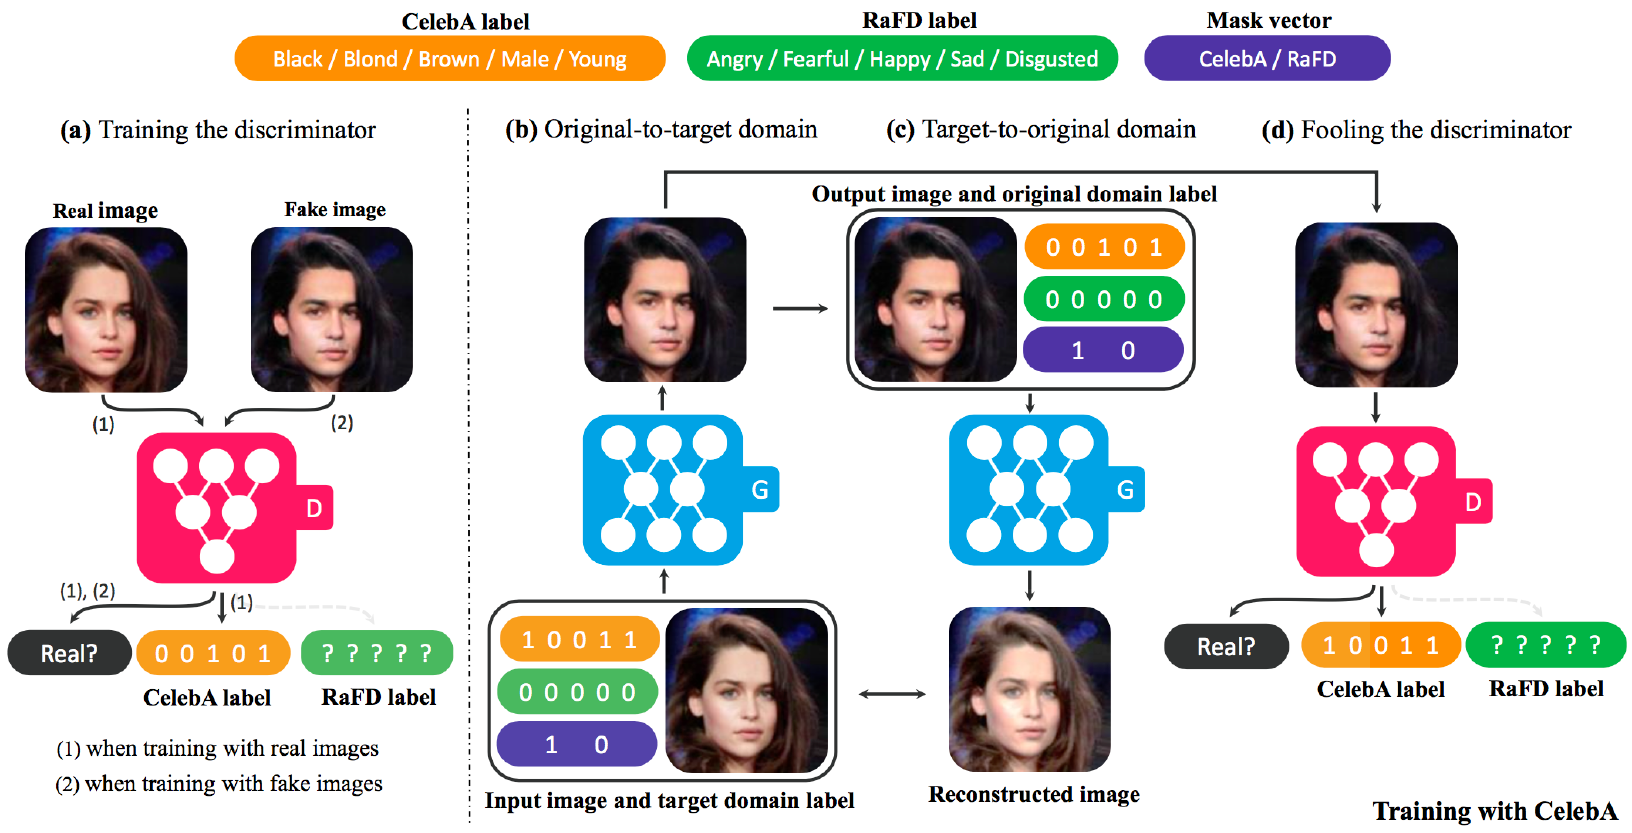![image](https://i.imgur.com/O1VrGT1.png)

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

for epoch in range(epoch, n_epochs):
    for i, (imgs, labels) in enumerate(tqdm(dataloader)):
        # Model inputs
        imgs = imgs.type(Tensor)
        labels = labels.type(Tensor)
        
        # Sample labels as generator inputs
        sampled_c = Tensor(np.random.randint(0, 2, (imgs.size(0), c_dim)))
        # Generate fake batch of images
        fake_imgs = generator(imgs, sampled_c)
        
# -------------------
# Train Discriminator
# -------------------
        optimizer_D.zero_grad()
    
        # Real images
        real_validity, pred_cls = discriminator(imgs)
        # Fake images
        fake_validity, _ = discriminator(fake_imgs.detach())
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, imgs.data, fake_imgs.data)
        # Adversarial loss
        loss_D_adv = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp*gradient_penalty
        # Classification loss
        loss_D_cls = criterion_cls(pred_cls, labels)
        # Total loss
        loss_D = loss_D_adv + lambda_cls*loss_D_cls
        
        loss_D.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        
        # Every n_critic times update generator
        if i % n_critic == 0: # n_critic : 5

        # -------------------
        # Train Generator
        # -------------------
            # Translate and reconstruct image
            gen_imgs = generator(imgs, sampled_c)
            recov_imgs = generator(gen_imgs, labels)
            # Discriminator evaluates translated image
            fake_validity, pred_cls = discriminator(gen_imgs)
            # Adversarial loss
            loss_G_adv = -torch.mean(fake_validity)
            # Classification loss
            loss_G_cls = criterion_cls(pred_cls, sampled_c)
            # Reconstruction loss
            loss_G_rec = criterion_cycle(recov_imgs, imgs)
            # Total loss
            loss_G = loss_G_adv + lambda_cls*loss_G_cls + lambda_rec*loss_G_rec
            
            loss_G.backward()
            optimizer_G.step()
            
        # -------------------
        # Show Progress
        # -------------------
        if (i+1) % 21 == 0: 
            sample_images()
            print("[Epoch %d/%d] [Batch %d/%d] [D adv: %f, aux: %f] [G loss: %f, adv: %f, aux: %f, cycle: %f]"
                % (
                    epoch+1, n_epochs,                     # Epoch
                    i+1,len(dataloader),                   # Batch
                    loss_D_adv.item(),loss_D_cls.item(),   # D loss
                    loss_G.item(),loss_G_adv.item(),       # G loss (total, adv)
                    loss_G_cls.item(),loss_G_rec.item(),   # G loss (cls, cycle)
                ))



> TEST CODE : np.random.randint

In [ ]:
# 16x5 array that contains 0 or 1
print(np.random.randint(0,2,(16,5)))
print('--------------')
print(np.random.randint(0,2,(16,5)).shape)


So far, we have looked at stargan, which can express various domains at once. 

Since it was meaningful to implement the code, we went on to test the model with a very small dataset (1k) and a small epoch (5). If you have enough time, consider implementing a better-performing model with more data.

If it was helpful, please share it with upvote for more people to see, and continue to study with me through more kernels.

Thank You!